In [ ]:
# libraires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


**Data Wrangling:**


1.   Loading
2.   Renaming colns
3.   drop columns
4.   keep popular items
5.   all products do not have same dates, create same dates
6.   make columns for each items sales
7.   One-hot encoding of date
8.   Shift Time-Series to Supervise Learning
9.   order colns
10.  making train-test data




In [ ]:
# data reading
def data_loading(path="/content/drive/My Drive/Colab Notebooks/単品商品の売上予測 (ステップ３)/data/"):
  df_old = pd.read_csv(path+"transactions_tenpo013_old.csv",  parse_dates=['売上日'],encoding='cp932') # encoding for cols name
  df_new = pd.read_csv(path+"transactions_tenpo013_201112.csv",  parse_dates=['売上日'],encoding='cp932') # encoding for cols name
  tokubai = pd.read_csv(path+"tokubai_data_013.csv", encoding='cp932')
  return [df_old, df_new, tokubai]

In [ ]:
df_old, df_new, tokubai = data_loading()

In [ ]:
# concating the old and new data
df_total  = pd.concat([df_old, df_new]).drop_duplicates().reset_index(drop=True)
df_total.head()

商品コード        売上日  店舗コード   定番売価  ...  中分類コード  小分類コード   分類コード  売上点数
0  4987072064153 2016-01-02     13  761.0  ...      13    1373  1373.0     2
1  4970114169145 2016-01-02     13  158.0  ...      15    1562  1562.0     2
2  4901734000280 2016-01-02     13  398.0  ...      13    1370  1370.0     4
3  4984948311458 2016-01-02     13  379.0  ...      14    1401  1401.0     1
4  4970114174422 2016-01-02     13  189.0  ...      15    1562  1562.0     1

[5 rows x 10 columns]

In [ ]:
# keep only the sales data: [date, store, item, chu, sales]
# Rename df
df = df_total.copy()
df.columns = ['item', 'date', 'store','teibanbaika', 'nebikikin','dai','chu','sho','bunrui','sales']
df = df.loc[:,['date', 'store', 'item','chu', 'sales']]

In [ ]:
#df_total[df_total.商品コード == 4548779700241]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1790022 entries, 0 to 1790021
Data columns (total 5 columns):
 #   Column  Dtype         
---  ------  -----         
 0   date    datetime64[ns]
 1   store   int64         
 2   item    int64         
 3   chu     int64         
 4   sales   int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 68.3 MB


In [ ]:
df.head()

date  store           item  chu  sales
0 2016-01-02     13  4987072064153   13      2
1 2016-01-02     13  4970114169145   15      2
2 2016-01-02     13  4901734000280   13      4
3 2016-01-02     13  4984948311458   14      1
4 2016-01-02     13  4970114174422   15      1

In [ ]:
def shouhin_shurui(temp, chu_bun_list=[], min_days=700, max_days=50000, start='2020-10-01', end= '2020-10-31'):

  if len(chu_bun_list) != 0:                     # list is not empty  
    temp = temp[temp['chu'].isin(chu_bun_list)]  #1 Choose 中分類 = [a, b]
    print("After selecting chubunrui unique items:", temp.item.nunique())

  sale_gr = temp.groupby( ['item'], as_index=False )['date'].count() # #2 count sale dates for each items

  #3 Filter based on min and max days
  ninki_item = list( sale_gr[ (sale_gr.date >= min_days) ].item ) # have atleast n days data , listing those items
  temp = temp[temp['item'].isin(ninki_item)]  # filter out items # dataframe is updating!!
  print("After specific days data having, unique items:",temp.item.nunique())

  #4 Choose items that have data from 20/10/01 till 2020/10/31 for predeiction
  mask = temp['date'] > start
  val = temp.loc[mask]
  temp = temp[temp['item'].isin(val.item)] 
  print("After having October,2020 data, unique items:",temp.item.nunique())

  return list(temp.item.unique())

In [ ]:
# Filrtering only most sale items
most_sale_list = shouhin_shurui(df.copy() ,chu_bun_list=[8,9]) # Having atleast n months of data, chu = [8,9]
#most_sale_list[0:5]

After selecting chubunrui unique items: 341
After specific days data having, unique items: 92
After having October,2020 data, unique items: 85


In [ ]:
df = df[ df['item'].isin(most_sale_list) ].reset_index( drop='True' )
df.head()

date  store           item  chu  sales
0 2016-01-02     13  4908851950108    8      1
1 2016-01-02     13       49380743    9      1
2 2016-01-02     13  4930726100318    9      2
3 2016-01-02     13  4930726100172    9      1
4 2016-01-02     13  4930726100349    9      1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91698 entries, 0 to 91697
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    91698 non-null  datetime64[ns]
 1   store   91698 non-null  int64         
 2   item    91698 non-null  int64         
 3   chu     91698 non-null  int64         
 4   sales   91698 non-null  int64         
dtypes: datetime64[ns](1), int64(4)
memory usage: 3.5 MB


In [ ]:
from itertools import product, starmap

def storeitems(df):
  df = df[ df['item'].isin(most_sale_list) ].reset_index( drop='True' )
  items = df.item.unique() # items = (items list)
  stores = df.store.unique() # stores = (shop_list)
  return product( items, stores ) #  => (item, shop) set

# change the dataframe to have same dates: start_date -> End_date
def date_fix(df):
    #genrate date
    ret = pd.DataFrame()
    date_df = pd.DataFrame()
    date_df['date'] = pd.to_datetime(df['date'].unique())

    for i,s in storeitems(df):
      filter_df = df[ (df.item == i)  & (df.store==s) ]
      filter_df = pd.merge( date_df, filter_df, how='left',on='date' )
      filter_df['item'].fillna(i, inplace=True)
      filter_df['store'].fillna(s, inplace=True)
      filter_df['sales'].fillna(0, inplace=True)
      ret = ret.append( filter_df, ignore_index=True )

    return ret


In [ ]:
df = date_fix(df)
df.info() # int64->float64 of colns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148835 entries, 0 to 148834
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    148835 non-null  datetime64[ns]
 1   store   148835 non-null  float64       
 2   item    148835 non-null  float64       
 3   chu     91698 non-null   float64       
 4   sales   148835 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 5.7 MB


In [ ]:
df.head()

date  store          item  chu  sales
0 2016-01-02   13.0  4.908852e+12  8.0    1.0
1 2016-01-03   13.0  4.908852e+12  NaN    0.0
2 2016-01-04   13.0  4.908852e+12  8.0    2.0
3 2016-01-05   13.0  4.908852e+12  NaN    0.0
4 2016-01-06   13.0  4.908852e+12  8.0    2.0

In [ ]:
# [store,items, chu, sales] became float64 type
df = df.astype({'item': 'int64', 'store':'int64', 'sales':'int64'})

In [ ]:
df['date'] = pd.to_datetime( df['date'] )
df.index = pd.DatetimeIndex( df['date'] )

df.drop( ['date','chu'], axis=1, inplace=True )

In [ ]:
def storeitems_column_names(df):
    # return items names
    col_name = list(starmap(lambda i,s: f'i_{i}_s_{s}_sales', storeitems(df))) # starmap(function, iterable)
    return col_name


def sales_by_storeitem(df):
    ret = pd.DataFrame(index=df.index.unique()) #index
    for item, store in storeitems(df): # (item, store)
        ret[f'i_{item}_s_{store}_sales'] = df[(df['item'] == item) & (df['store'] == store)]['sales'].values
    return ret


In [ ]:
df_train = sales_by_storeitem(df) # make rows to individual columns of items date as index

In [ ]:
df_train.head()

i_4908851950108_s_13_sales  ...  i_4901001397457_s_13_sales
date                                    ...                            
2016-01-02                           1  ...                           0
2016-01-03                           0  ...                           0
2016-01-04                           2  ...                           0
2016-01-05                           0  ...                           0
2016-01-06                           2  ...                           0

[5 rows x 85 columns]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1751 entries, 2016-01-02 to 2020-11-11
Data columns (total 85 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   i_4908851950108_s_13_sales  1751 non-null   int64
 1   i_49380743_s_13_sales       1751 non-null   int64
 2   i_4930726100318_s_13_sales  1751 non-null   int64
 3   i_4930726100172_s_13_sales  1751 non-null   int64
 4   i_4930726100349_s_13_sales  1751 non-null   int64
 5   i_4901520118809_s_13_sales  1751 non-null   int64
 6   i_4971666410181_s_13_sales  1751 non-null   int64
 7   i_4901520132225_s_13_sales  1751 non-null   int64
 8   i_4901870121610_s_13_sales  1751 non-null   int64
 9   i_4901870115404_s_13_sales  1751 non-null   int64
 10  i_4901870122938_s_13_sales  1751 non-null   int64
 11  i_4901870122648_s_13_sales  1751 non-null   int64
 12  i_4901870122792_s_13_sales  1751 non-null   int64
 13  i_4901870122952_s_13_sales  1751 non-null   i

In [ ]:
# One-Hot Encoding
weekday_df = pd.get_dummies(df_train.index.weekday, prefix='weekday')
weekday_df.index = df_train.index

month_df = pd.get_dummies(df_train.index.month, prefix='month')
month_df.index =  df_train.index

# concat week, month, sales data together
df_train = pd.concat([weekday_df, month_df, df_train], axis=1)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1751 entries, 2016-01-02 to 2020-11-11
Columns: 104 entries, weekday_0 to i_4901001397457_s_13_sales
dtypes: int64(85), uint8(19)
memory usage: 1.2 MB


In [ ]:
df_train.head()

weekday_0  ...  i_4901001397457_s_13_sales
date                   ...                            
2016-01-02          0  ...                           0
2016-01-03          0  ...                           0
2016-01-04          1  ...                           0
2016-01-05          0  ...                           0
2016-01-06          0  ...                           0

[5 rows x 104 columns]

In [ ]:
# Useful functions
def shift_series(series, days):
    return series.transform(lambda x: x.shift(days)) # (days==positive) => push Forward
                                                     # (days==negative) => push Back


def shift_series_in_df(df, series_names=[], days_delta=90):
    """
    Shift columns in df with names in series_names by days_delta.
    
    Negative days_delta will prepend future values to current date,
    positive days_delta wil prepend past values to current date.
    """
    ret = pd.DataFrame(index=df.index.copy())
    str_sgn = 'future' if np.sign(days_delta) < 0 else 'past'
    for sn in series_names:
        ret[f'{sn}_{str_sgn}_{np.abs(days_delta)}'] = shift_series(df[sn], days_delta)
    return ret

    
def stack_shifted_sales(df, df_prev, days_delta=90):
    names =  storeitems_column_names(df_prev) # get colns name
    dfs = [df.copy()]
    abs_range = range(1, days_delta+1) if days_delta > 0 else range(days_delta, 0)
    for day_offset in abs_range:
        delta = -day_offset
        shifted = shift_series_in_df(df, series_names=names, days_delta=delta)
        dfs.append(shifted)
    return pd.concat(dfs, axis=1, copy=False)

In [ ]:
df_train = stack_shifted_sales(df_train, df, days_delta=-1)
df_train.head()

weekday_0  ...  i_4901001397457_s_13_sales_past_1
date                   ...                                   
2016-01-02          0  ...                                NaN
2016-01-03          0  ...                                0.0
2016-01-04          1  ...                                0.0
2016-01-05          0  ...                                0.0
2016-01-06          0  ...                                0.0

[5 rows x 189 columns]

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1751 entries, 2016-01-02 to 2020-11-11
Columns: 189 entries, weekday_0 to i_4901001397457_s_13_sales_past_1
dtypes: float64(85), int64(85), uint8(19)
memory usage: 2.3 MB


In [ ]:
df_train = df_train.dropna() # only first row will be dropped

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1750 entries, 2016-01-03 to 2020-11-11
Columns: 189 entries, weekday_0 to i_4901001397457_s_13_sales_past_1
dtypes: float64(85), int64(85), uint8(19)
memory usage: 2.3 MB


In [ ]:
# make sure stacked and standard sales columns appear in the same order:
sales_cols = [col for col in df_train.columns if '_sales' in col and '_sales_' not in col]

stacked_sales_cols = [col for col in df_train.columns if '_sales_' in col]

other_cols = [col for col in df_train.columns if col not in set(sales_cols) and col not in set(stacked_sales_cols)]



In [ ]:
# Sorting cols names
sales_cols = sorted(sales_cols)
stacked_sales_cols = sorted(stacked_sales_cols)

new_cols = other_cols + stacked_sales_cols + sales_cols

In [ ]:
# ordered colns
df_train = df_train.reindex(columns=new_cols)

In [ ]:
assert df_train.isna().any().any() == False

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# shifted sales cols 
X_cols_stacked = [col for col in df_train.columns if '_past_' in col]

# calender cols
X_cols_caldata = [col for col in df_train.columns if 'weekday_' in col or 'month_' in col]

# all colmns together
X_cols = X_cols_stacked + X_cols_caldata

X = df_train[X_cols]  # Past data is input data X

In [ ]:
print(f'X_cols_stacked: {X_cols_stacked}')
print(f'X_cols_caldata: {X_cols_caldata}')
#print(f'X_cols: {X_cols}')
print(f'X_cols length: {len(X_cols)}')

X_cols_stacked: ['i_4571268296918_s_13_sales_past_1', 'i_4571268297427_s_13_sales_past_1', 'i_4571268297632_s_13_sales_past_1', 'i_4571268297762_s_13_sales_past_1', 'i_4901001131372_s_13_sales_past_1', 'i_4901001140367_s_13_sales_past_1', 'i_4901001150564_s_13_sales_past_1', 'i_4901001284559_s_13_sales_past_1', 'i_4901001359417_s_13_sales_past_1', 'i_4901001397457_s_13_sales_past_1', 'i_4901033630690_s_13_sales_past_1', 'i_4901033631307_s_13_sales_past_1', 'i_4901231900120_s_13_sales_past_1', 'i_4901520118809_s_13_sales_past_1', 'i_4901520132225_s_13_sales_past_1', 'i_4901870115404_s_13_sales_past_1', 'i_4901870121610_s_13_sales_past_1', 'i_4901870122648_s_13_sales_past_1', 'i_4901870122754_s_13_sales_past_1', 'i_4901870122792_s_13_sales_past_1', 'i_4901870122839_s_13_sales_past_1', 'i_4901870122938_s_13_sales_past_1', 'i_4901870122945_s_13_sales_past_1', 'i_4901870122952_s_13_sales_past_1', 'i_4901870122969_s_13_sales_past_1', 'i_4901870123898_s_13_sales_past_1', 'i_4901870124246_s_13

In [ ]:
X_colset = set(X_cols) # set() delete duplitcates
print(f'X_cols length: {len(X_cols)}')
#print(f'df_train length: {len(df_train.columns)}')

y_cols = [col for col in df_train.columns if col not in X_colset]
print(f'y_cols length: {len(y_cols)}')

# Creating y
y = df_train[y_cols]

X_cols length: 104
y_cols length: 85


In [ ]:
# Train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) # returns: dataFrame
X_train = X.loc[ X.index < '2020-10-01' ]
#X_valid = X.loc[ (X.index >= '2020-09-01') & (X.index < '2020-10-01') ]
X_test = X.loc[ (X.index >= '2020-10-01') & (X.index<'2020-11-01') ]



y_train = y.loc[ y.index < '2020-10-01' ]
#y_valid = y.loc[ (y.index >= '2020-09-01') & (y.index < '2020-10-01') ]
y_test = y.loc[ (y.index >= '2020-10-01') & (y.index < '2020-11-01')]

In [ ]:
# rehsape for feed into Neural net
print("Before X_train : ",X_train.shape)
X_train = X_train.values.reshape((X_train.shape[0], 1, X_train.shape[1]))
print("After X_train: ", X_train.shape)
#X_valid = X_valid.values.reshape((X_valid.shape[0], 1, X_valid.shape[1]))

Before X_train :  (1708, 104)
After X_train:  (1708, 1, 104)


**Model Building & Train**

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, AvgPool1D, Concatenate

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

path = "checkpoint_best_only/checkpoint" 
def model_check():
    model_checkpoint = ModelCheckpoint(filepath=path,
                                      monitor="val_acc",
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True,
                                      save_freq=True)
    return model_checkpoint

def early_check():
    return EarlyStopping(monitor="val_loss", patience=10, verbose=1)

In [ ]:
# function: building Neural Network model
def build_model():
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]), name="Input_layer_1") # (1, 519)
    
    # top pipeline
    top_lstm = LSTM(264, return_sequences=True, name="LSTM_1")(inputs)
    top_dense = Dense(100, activation='relu', name="Dense_1")(top_lstm)
    
    # bottom pipeline
    bottom_dense = Dense(100, name="Dense_2")(inputs)
    bottom_conv1 = Conv1D(
        100, 
        kernel_size=1,
        input_shape=(X_train.shape[1], X_train.shape[2]),  # (1, 519)
        name="Con1D_1"
    )(bottom_dense)
    bottom_conv2 = Conv1D(
        200,
        kernel_size=50,
        padding='same',
        activation='relu',
        name="Conv1D_2"
    )(bottom_conv1)
    bottom_conv3 = Conv1D(
        100,
        kernel_size=10,
        padding='same',
        activation='relu',
        name="Conv1D_3"
    )(bottom_conv2)
    bottom_pooling = AvgPool1D(
        pool_size=10, 
        padding='same',
        name="AvgPool1D_1"
    )(bottom_conv3)
#     bottom_reshape = Reshape(
#         target_shape=[500]
#     )(bottom_conv3)

    # concat output    
    final_concat = Concatenate()([top_dense, bottom_pooling])
    
    final_lstm = LSTM(264, dropout=0.2, name="LSTM_2")(final_concat)
    final_dense = Dense(y_train.shape[1], name="Dense_3")(final_lstm)
    
    # compile and return
    model = Model(inputs=inputs, outputs=final_dense)
    adam = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=adam, metrics=['mean_absolute_error'])
    return model



In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input_layer_1 (InputLayer)      [(None, 1, 104)]     0                                            
__________________________________________________________________________________________________
Dense_2 (Dense)                 (None, 1, 100)       10500       Input_layer_1[0][0]              
__________________________________________________________________________________________________
Con1D_1 (Conv1D)                (None, 1, 100)       10100       Dense_2[0][0]                    
__________________________________________________________________________________________________
Conv1D_2 (Conv1D)               (None, 1, 200)       1000200     Con1D_1[0][0]                    
______________________________________________________________________________________________

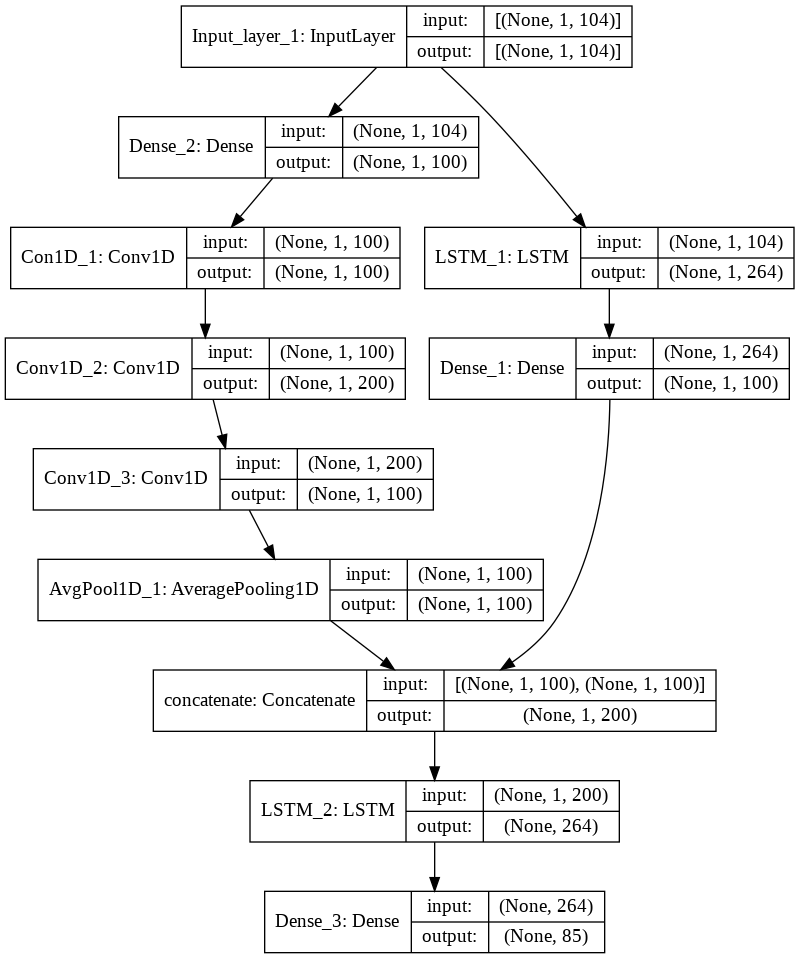

In [ ]:
# Visualize the model
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=True, dpi=96)

In [ ]:
# Creating callbacks
model_check = model_check()
early_check = early_check()
callbacks = [model_check, early_check]

In [ ]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=150, 
    batch_size=31,
    #validation_data=(X_valid, y_valid),
    validation_split=0.03,
    verbose=1,
    shuffle=False
    #callbacks=early_check
)

Epoch 1/150
54/54 [==============================] - 4s 21ms/step - loss: 0.8447 - mean_absolute_error: 1.2241 - val_loss: 0.9093 - val_mean_absolute_error: 1.3152
Epoch 2/150
54/54 [==============================] - 0s 7ms/step - loss: 0.8774 - mean_absolute_error: 1.2809 - val_loss: 0.9271 - val_mean_absolute_error: 1.3282
Epoch 3/150
54/54 [==============================] - 0s 7ms/step - loss: 0.8616 - mean_absolute_error: 1.2653 - val_loss: 0.9203 - val_mean_absolute_error: 1.3226
Epoch 4/150
54/54 [==============================] - 0s 7ms/step - loss: 0.8710 - mean_absolute_error: 1.2735 - val_loss: 0.9210 - val_mean_absolute_error: 1.3218
Epoch 5/150
54/54 [==============================] - 0s 7ms/step - loss: 0.8765 - mean_absolute_error: 1.2812 - val_loss: 0.9427 - val_mean_absolute_error: 1.3430
Epoch 6/150
54/54 [==============================] - 0s 7ms/step - loss: 0.8570 - mean_absolute_error: 1.2607 - val_loss: 0.9190 - val_mean_absolute_error: 1.3196
Epoch 7/150
54/54 [==

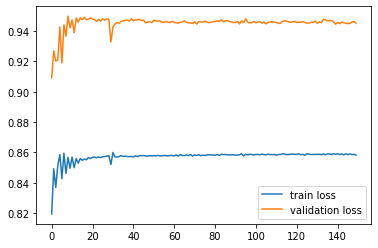

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
hist = pd.DataFrame(history.history)
hist.tail()

loss  mean_absolute_error  val_loss  val_mean_absolute_error
145  0.858515             1.261604  0.945081                 1.350205
146  0.859046             1.262201  0.945064                 1.349808
147  0.858573             1.261636  0.946064                 1.350369
148  0.858738             1.261698  0.946357                 1.350259
149  0.858199             1.261212  0.945158                 1.349247

In [ ]:
# Model 2
model_2=Sequential()
model_2.add(LSTM(264, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model_2.add(LSTM(128, dropout=0.2, return_sequences=True))
# model_2.add(LSTM(64, dropout=0.2, activation='relu', return_sequences=True))
model_2.add(Dense(y_train.shape[1]))

In [ ]:
# Compile the 2nd model
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
model_2.compile(loss=tf.keras.losses.Huber(), optimizer=adam, metrics=['mean_absolute_error'])

In [ ]:
model_2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_7 (LSTM)                (None, 1, 264)            389664    
_________________________________________________________________
dense_5 (Dense)              (None, 1, 85)             22525     
Total params: 412,189
Trainable params: 412,189
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model_2.fit(
    X_train, 
    y_train, 
    epochs=150, 
    batch_size=64,
    #validation_data=(X_valid, y_valid),
    validation_split=0.03,
    verbose=1,
    shuffle=False,
    callbacks=early_check
)

Epoch 1/150
26/26 [==============================] - 1s 17ms/step - loss: 0.9146 - mean_absolute_error: 1.3038 - val_loss: 0.9953 - val_mean_absolute_error: 1.4098
Epoch 2/150
26/26 [==============================] - 0s 5ms/step - loss: 0.8798 - mean_absolute_error: 1.2805 - val_loss: 0.9887 - val_mean_absolute_error: 1.3998
Epoch 3/150
26/26 [==============================] - 0s 5ms/step - loss: 0.8568 - mean_absolute_error: 1.2607 - val_loss: 0.9970 - val_mean_absolute_error: 1.4078
Epoch 4/150
26/26 [==============================] - 0s 6ms/step - loss: 0.8117 - mean_absolute_error: 1.2114 - val_loss: 0.9673 - val_mean_absolute_error: 1.3741
Epoch 5/150
26/26 [==============================] - 0s 6ms/step - loss: 0.8278 - mean_absolute_error: 1.2349 - val_loss: 0.9468 - val_mean_absolute_error: 1.3495
Epoch 6/150
26/26 [==============================] - 0s 6ms/step - loss: 0.8084 - mean_absolute_error: 1.2127 - val_loss: 0.9457 - val_mean_absolute_error: 1.3562
Epoch 7/150
26/26 [==

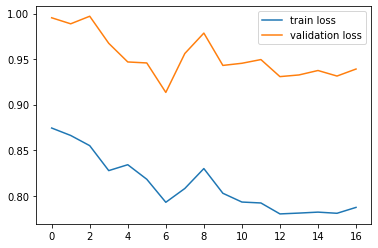

In [ ]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.legend()
plt.show()

In [ ]:
def model_eval(model, X_test, y_test, log_all=False):
    """
    Model must have #predict method.
    X_test, y_test - instances of pd.DataFrame (normal, not reshaped for LSTM !!!)
    
    Note that this function assumes that sales columns for previous values appear 
    in the same order as sales columns for current values.

    *** predict method can predict only one value at a time so loop is been used.
    """
    # prepare data
    sales_x_cols = [col for col in X_test.columns if 'sales' in col]
    sales_x_idxs = [X_test.columns.get_loc(col) for col in sales_x_cols] # making colns index
    #print(f'sales_x_idxs: {len(sales_x_idxs)}')# 3500

    sales_y_cols = [col for col in y_test.columns if 'sales' in col]
    sales_y_idxs = [y_test.columns.get_loc(col) for col in sales_y_cols] # making colns index
    #print(f'Sales_y_idxs: {sales_y_idxs}') # shape: 500

    n_samples = y_test.shape[0] # rows as y_test
    #print(n_samples)

    y_pred = np.zeros(y_test.shape) # 
    #print(y_test.shape)

    # iterate
    x_next = X_test.iloc[0].values # initialize 'x_next'
    #print( np.array([x_next]).shape) # (1, 3519)
    flag = False
    for i in range(0, n_samples):
        if log_all:
            print('[x]', x_next)
        x_arr = np.array([x_next])

        if flag:
          print(f'begin: {x_arr[i][sales_y_idxs]}')

        x_arr = x_arr.reshape(x_arr.shape[0], 1, x_arr.shape[1])
        #print(x_arr.shape) #(1, 1, 3519)
        y_pred[i] = model.predict(x_arr)[0]
        #print(y_pred) #(364, 500)

        if flag:
          print(f'Prediction : {y_pred[i]}')

        try:
            x_next = X_test.iloc[i+1].values # selecting only one row
            #print(x_next.shape) # (3519,)
            #print(x_next[sales_x_idxs].shape) # (3500,) excluding 'cal_data'
            #print(y_pred[i][sales_y_idxs].shape) # (500,)
            # This line can be use if we want to predict when X_text is not available
            #x_next[sales_x_idxs] = y_pred[i][sales_y_idxs] # Bug: shape mismatch: value array of shape (500,) could not be broadcast to indexing result of shape (3500,) fixed: Days -1

            if flag:
              print(f'At end: {x_next}')
              flag = False
        except IndexError:
            pass  # this happens on last iteration, and x_next does not matter anymore
    return y_pred, y_test.values



In [ ]:
# Prediction 
y_pred, y_real = model_eval(model, X_test, y_test)

In [ ]:
y_test = pd.DataFrame(data=y_test, columns=y_cols)
y_pred = pd.DataFrame(data=y_pred, columns=y_cols)

In [ ]:
y_test.head()

i_4571268296918_s_13_sales  ...  i_49839821_s_13_sales
date                                    ...                       
2020-10-01                           2  ...                      4
2020-10-02                           1  ...                      1
2020-10-03                           2  ...                      0
2020-10-04                           2  ...                      0
2020-10-05                           0  ...                      1

[5 rows x 85 columns]

In [ ]:
y_pred.head()

i_4571268296918_s_13_sales  ...  i_49839821_s_13_sales
0                    1.009768  ...               1.098827
1                    1.009768  ...               1.098827
2                    1.009768  ...               1.098827
3                    1.009768  ...               1.098827
4                    1.009768  ...               1.098827

[5 rows x 85 columns]

In [ ]:
y_pred = np.ceil(y_pred)

In [ ]:
y_pred = pd.DataFrame(data=y_pred, index=y_test.index)

In [ ]:
y_pred.head()

i_4571268296918_s_13_sales  ...  i_49839821_s_13_sales
date                                    ...                       
2020-10-01                         NaN  ...                    NaN
2020-10-02                         NaN  ...                    NaN
2020-10-03                         NaN  ...                    NaN
2020-10-04                         NaN  ...                    NaN
2020-10-05                         NaN  ...                    NaN

[5 rows x 85 columns]

In [ ]:
# error analysis: MSE
from sklearn.metrics import mean_squared_error

def vector_rmse(y_pred, y_real, col):
    mse = mean_squared_error( y_real, y_pred, squared=False )  # in percent,
    #rmse = np.sqrt(mse)
    print(f'col: {col}: {mse}')
    return mse

In [ ]:
mse = [vector_rmse(y_pred[col], y_test[col], col) for col in y_pred.columns]

ValueError: ignored

In [ ]:
import seaborn as sns
sns.distplot(mse)

In [ ]:
# Train test split
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False) # returns: dataFrame
X_train = X.loc[ X.index < '2020-09-01' ]
X_valid = X.loc[ (X.index >= '2020-09-01') & (X.index < '2020-10-01') ]
X_test = X.loc[ (X.index >= '2020-10-01') & (X.index<'2020-11-01') ]



y_train = y.loc[ y.index < '2020-09-01' ]
y_valid = y.loc[ (y.index >= '2020-09-01') & (y.index < '2020-10-01') ]
y_test = y.loc[ (y.index >= '2020-10-01') & (y.index < '2020-11-01')]

In [ ]:
# Gradient Boost
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor(random_state=0)
reg.fit(X_train.loc[:, X_cols_stacked], y_train)

ValueError: ignored

In [ ]:
X_train.loc[:, X_cols_stacked].shape

(1678, 85)